Let's import all the libraries and classes we will need while making this project

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import Regularizer

import tensorflow.keras.utils as ku 
import numpy as np 

# Importing Data

Now we will read the data. I'm reading the data from my github profile link, you can directly use txt files. 

In [9]:
import urllib.request

url = "https://raw.githubusercontent.com/ishantjuyal/Word-Prediction/master/Lyrics%20by%20Artists/Kanye_West.txt"
data = urllib.request.urlopen(url).read().decode("utf-8")

In [10]:
len(data)

251069

In [11]:
data

'\ufeffEighteen years eighteen years\nShe got one of your kids got you for eighteen years\nI know somebody paying child support for one of his kids\nHis baby mama car and crib is bigger than his\nYou will see him on TV any given Sunday\nWin the Super Bowl and drive off in a Hyundai\nShe was supposed to buy your shorty Tyco with your money\nShe went to the doctor got lipo with your money\nShe walking around looking like Michael with your money\nShouldve got that insured Geico for your money\nIf you aint no punk\nHolla We want prenup We want prenup Yeah\nIts something that you need to have\nCause when she leave your ass she gon leave with half\nEighteen years eighteen years\nAnd on the the birthday he found out it wasnt his\nNow I aint saying you a gold digger you got needs\nYou dont want a dude to smoke but he cant buy weed\nYou go out to eat and he cant pay yall cant leave\nTheres dishes in the back he gotta roll up your sleeves\nBut while yall washin watch him\nHe gone make it into a 

Now we will convert data, which is a string to a list containing differrent sentences. 
As we can see, in the string, "end of line" is represented by "\r\n". So, we will split the string by "\r\n" and store them as list in corpus.

In [12]:
# Splitting the string into sentences, while converting whole data into lowercase. 
corpus = data.lower().split("\n")

# Now, to make sure no sentence appears twice in our corpus, we use set. Otherwise, it will make the model biased.
corpus = list(set(corpus))

In [13]:
for i in range(len(corpus)):
    sentence = corpus[i]
    sentence = "startsentence " + sentence + " endsentence"
    corpus[i] = sentence

Let's see how an element of corpus looks like. 

In [14]:
corpus[3]

'startsentence well whos maybach is this mr wests endsentence'

As we can see, it is just a sentence without any "\r or \n"

# Organising Data
Now we will use Tokenizer to convert the words to word vectors. 
Our model understands numbers only, so we need to give it numbers instead of words. 

In [15]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [16]:
print("Input Sequences")
print(input_sequences)
print("*****")
print("Shape of Input Sequences", input_sequences.shape)

Input Sequences
[[   0    0    0 ...    0    1    2]
 [   0    0    0 ...    0    1 1331]
 [   0    0    0 ...    1 1331  245]
 ...
 [   0    0    0 ...  442   33 6143]
 [   0    0    0 ...   33 6143 1028]
 [   0    0    0 ... 6143 1028    2]]
*****
Shape of Input Sequences (56557, 21)


In [17]:
print("Predictors")
print(predictors)
print('*****')
print("Shape of predictors is", predictors.shape)

Predictors
[[   0    0    0 ...    0    0    1]
 [   0    0    0 ...    0    0    1]
 [   0    0    0 ...    0    1 1331]
 ...
 [   0    0    0 ...    6  442   33]
 [   0    0    0 ...  442   33 6143]
 [   0    0    0 ...   33 6143 1028]]
*****
Shape of predictors is (56557, 20)


In [18]:
print("Label")
print(label)
print("*****")
print("Shape of label", label.shape)

Label
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
*****
Shape of label (56557, 6144)


Now, we will start building model using Keras. We use LSTM so that our model could be more accurate and understand the context better. 

In [19]:
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))  #(# Embedding Layer)
model.add(Bidirectional(LSTM(150, return_sequences=True)))  #(An LSTM Layer)
model.add(Dropout(0.2))  #(# A dropout layer for regularisation)
model.add(LSTM(100))  #(# Another LSTM Layer)
model.add(Dense(total_words/2, activation='relu'))  #(# A Dense Layer including regularizers)
#(# Last Layer, the shape is equal to total number of words present in our vocabulary)
model.add(Dense(total_words, activation='softmax'))  
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            307200    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 300)           241200    
_________________________________________________________________
dropout (Dropout)            (None, 20, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 3072)              310272    
_________________________________________________________________
dense_1 (Dense)              (None, 6144)              18880512  
Total params: 19,899,584
Trainable params: 19,899,584
Non-trainable params: 0
____________________________________________

In [20]:
history = model.fit(predictors, label, epochs= 120, verbose=1)

Epoch 1/120
1768/1768 [==============================] - 28s 16ms/step - loss: 6.2006 - accuracy: 0.1070
Epoch 2/120
1768/1768 [==============================] - 28s 16ms/step - loss: 5.7905 - accuracy: 0.1236
Epoch 3/120
1768/1768 [==============================] - 28s 16ms/step - loss: 5.5255 - accuracy: 0.1476
Epoch 4/120
1768/1768 [==============================] - 28s 16ms/step - loss: 5.3314 - accuracy: 0.1558
Epoch 5/120
1768/1768 [==============================] - 28s 16ms/step - loss: 5.1848 - accuracy: 0.1619
Epoch 6/120
1768/1768 [==============================] - 28s 16ms/step - loss: 5.0565 - accuracy: 0.1661
Epoch 7/120
1768/1768 [==============================] - 28s 16ms/step - loss: 4.9306 - accuracy: 0.1726
Epoch 8/120
1768/1768 [==============================] - 28s 16ms/step - loss: 4.8028 - accuracy: 0.1784
Epoch 9/120
1768/1768 [==============================] - 27s 16ms/step - loss: 4.6797 - accuracy: 0.1854
Epoch 10/120
1768/1768 [==============================]

Now, we will see how our model performed with each iteration. 

In [21]:
import matplotlib.pyplot as plt

def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

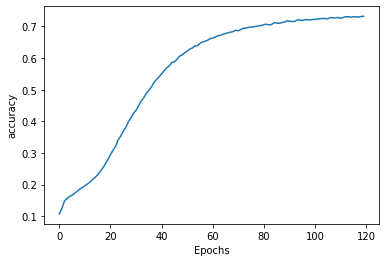

In [22]:
plot_graph(history,'accuracy')

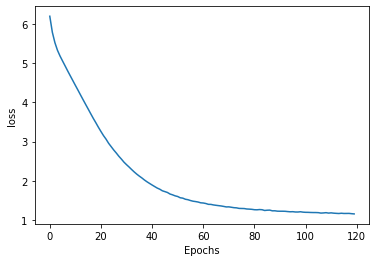

In [23]:
plot_graph(history,'loss')

In [24]:
# Further training if not satisfied
history = model.fit(predictors, label, epochs= 30, verbose=1)

Epoch 1/30
1768/1768 [==============================] - 27s 15ms/step - loss: 1.1631 - accuracy: 0.7320
Epoch 2/30
1768/1768 [==============================] - 27s 15ms/step - loss: 1.1510 - accuracy: 0.7320
Epoch 3/30
1768/1768 [==============================] - 27s 16ms/step - loss: 1.1527 - accuracy: 0.7335
Epoch 4/30
1768/1768 [==============================] - 27s 15ms/step - loss: 1.1466 - accuracy: 0.7339
Epoch 5/30
1768/1768 [==============================] - 27s 16ms/step - loss: 1.1559 - accuracy: 0.7328
Epoch 6/30
1768/1768 [==============================] - 28s 16ms/step - loss: 1.1426 - accuracy: 0.7356
Epoch 7/30
1768/1768 [==============================] - 27s 15ms/step - loss: 1.1486 - accuracy: 0.7345
Epoch 8/30
1768/1768 [==============================] - 27s 15ms/step - loss: 1.1427 - accuracy: 0.7363
Epoch 9/30
1768/1768 [==============================] - 27s 15ms/step - loss: 1.1511 - accuracy: 0.7329
Epoch 10/30
1768/1768 [==============================] - 27s 15m

In [42]:
# How to save your trained model

# serialize to JSON
json_file = model.to_json()
with open("model.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model.save_weights("model.h5")

In [44]:
# How to load your saved model

from keras.models import model_from_json

# load json and create model
file = open('model.json', 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights("model.h5")

# Generate Lyrics

In [29]:
def make_lyrics(seed_text):
    ans = True
    seed_text = "startsentence " + seed_text 
    while True:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == "endsentence":
            new_sentence_words = seed_text.split()[1:]
            seed_text = ' '.join(new_sentence_words)
            print(seed_text)
            ans = False
            break
        seed_text += " " + output_word
    if ans == True:
        new_sentence_words = seed_text.split()[1:]
        seed_text = ' '.join(new_sentence_words)
        print(seed_text)

In [31]:
make_lyrics("How")

How you gon lie to the lawyer


In [32]:
make_lyrics("When I will")

When I will make it to the other side of sanity


In [33]:
make_lyrics("Light in the")

Light in the morning you gon make it too soon


In [34]:
make_lyrics("Walking")

Walking down melrose spot where they sell clothes


In [35]:
make_lyrics("Do you")

Do you mind if i


In [36]:
make_lyrics("Why would")

Why would i mention your favorite song and you twerk


In [40]:
make_lyrics("She")

She said you left your kids and they just like you


In [45]:
make_lyrics("And all my people")

And all my people bitch black


In [46]:
make_lyrics("If this is")

If this is your first time hearin this
